In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
N = 100

In [4]:
L = 1000

In [5]:
T = 20

In [6]:
x = np.empty((N,L),np.float32)

In [7]:
x[:] = np.array(range(L)) + np.random.randint(-4*T,4*T,N).reshape(N,1)

In [8]:
y = np.sin(x/1.0/T).astype(np.float32)

In [18]:
x.shape

(100, 1000)

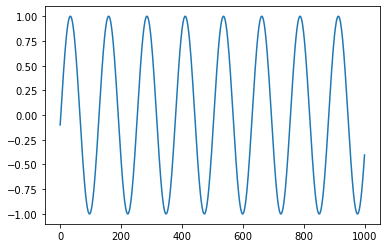

In [9]:
plt.figure()
plt.plot(np.arange(x.shape[1]),y[0,:])
plt.show()

In [10]:
class LSTMPredictor(nn.Module):
    def __init__(self,n_hidden=51):
        super().__init__()
        self.n_hidden = n_hidden
        # lstm1, lstm2, linear
        self.lstm1 = nn.LSTMCell(1,self.n_hidden)
        self.lstm2 = nn.LSTMCell(self.n_hidden,self.n_hidden)
        self.linear = nn.Linear(self.n_hidden,1)
    
    def forward(self,X,future=0):
        outputs = []
        n_samples = X.size(0)
        h_t = torch.zeros(n_samples,self.n_hidden,dtype=torch.float32)
        c_t = torch.zeros(n_samples,self.n_hidden,dtype=torch.float32)
        h_t2 = torch.zeros(n_samples,self.n_hidden,dtype=torch.float32)
        c_t2 = torch.zeros(n_samples,self.n_hidden,dtype=torch.float32)
        for input_t in X.split(1,dim=1):
            h_t,c_t = self.lstm1(input_t,(h_t,c_t))
            h_t2,c_t2 = self.lstm2(h_t,(h_t2,c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        for i in range(future):
            h_t,c_t = self.lstm1(output,(h_t,c_t))
            h_t2,c_t2 = self.lstm2(h_t,(h_t2,c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        outputs = torch.cat(outputs,dim=1)
        return outputs

In [11]:
device = 'cuda'

In [27]:
y.shape

(3, 1999)

In [30]:
test_input

tensor([[-0.0998, -0.0500,  0.0000,  ..., -0.5358, -0.4930, -0.4489],
        [ 0.3894,  0.4350,  0.4794,  ..., -0.0654, -0.0155,  0.0345],
        [-0.3894, -0.3429, -0.2955,  ..., -0.7614, -0.7281, -0.6929]])

In [31]:
test_target

tensor([[-0.0500,  0.0000,  0.0500,  ..., -0.4930, -0.4489, -0.4036],
        [ 0.4350,  0.4794,  0.5227,  ..., -0.0155,  0.0345,  0.0844],
        [-0.3429, -0.2955, -0.2474,  ..., -0.7281, -0.6929, -0.6560]])

In [28]:
test_input.shape

torch.Size([3, 999])

In [29]:
test_target.shape

torch.Size([3, 999])

In [12]:
# y = 100,1000
train_input = torch.from_numpy(y[3:,:-1])# 97,999
train_target = torch.from_numpy(y[3:,1:]) # 97,999
test_input = torch.from_numpy(y[:3,:-1]) # 3,999
test_target = torch.from_numpy(y[:3,1:]) # 3,99
model = LSTMPredictor()
criterion = nn.MSELoss()
optimizer = optim.LBFGS(model.parameters(),lr=0.8)

In [13]:
n_steps = 100

In [14]:
from tqdm import tqdm

In [25]:
test_input

tensor([[-0.0998, -0.0500,  0.0000,  ..., -0.5358, -0.4930, -0.4489],
        [ 0.3894,  0.4350,  0.4794,  ..., -0.0654, -0.0155,  0.0345],
        [-0.3894, -0.3429, -0.2955,  ..., -0.7614, -0.7281, -0.6929]])

In [24]:
test_target

tensor([[-0.0500,  0.0000,  0.0500,  ..., -0.4930, -0.4489, -0.4036],
        [ 0.4350,  0.4794,  0.5227,  ..., -0.0155,  0.0345,  0.0844],
        [-0.3429, -0.2955, -0.2474,  ..., -0.7281, -0.6929, -0.6560]])

In [15]:
for i in tqdm(range(n_steps)):
    def closure():
        optimizer.zero_grad()
        out = model(train_input)
        loss = criterion(out,train_target)
        loss.backward()
        return loss
    optimizer.step(closure)
    with torch.no_grad():
        future = 1000
        pred = model(test_input,future=future)
        loss = criterion(pred[:,:-future],test_target)
        y = pred.detach().numpy()
    plt.figure(figsize=(12,6))
    plt.title(f'Step : {i+1}')
    n = train_input.shape[1]
    def draw(y_i,color):
        plt.plot(np.arange(n),y_i[:n],color)
        plt.plot(np.arange(n,n+future),y_i[n:],color + ':')
    draw(y[0],'r')
    draw(y[1],'b')
    draw(y[2],'g')
    plt.savefig('./preds/predict%d.png'%i)
    plt.close()

100%|██████████| 100/100 [05:51<00:00,  3.51s/it]
